In [ ]:
pip install torch torchvision torchaudio

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Fungsi untuk membuat dataset dummy
def create_dummy_dataset(num_samples, input_size):
    X = np.random.rand(num_samples, 1, input_size, input_size)  # [batch, channel, height, width]
    y = np.random.randint(0, 2, num_samples)  # Binary classification
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

# Parameter
num_samples = 1000
input_size = 32
X, y = create_dummy_dataset(num_samples, input_size)

In [ ]:
# Membagi dataset menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat TensorDataset dan DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size, pooling_type):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, padding='same') # 1 channel (grayscale)
        self.relu = nn.ReLU()
        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
          raise ValueError("Pooling type harus 'max' atau 'avg'")
        self.fc = nn.Linear(16 * (input_size//2)**2, 2)  # Output size 2 for binary classification

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, early_stopping_patience=10, learning_rate_scheduler=True):

    if learning_rate_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if learning_rate_scheduler:
            scheduler.step(val_loss)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stopping_counter = 0
          print("Validation Loss Improved")
        else:
          early_stopping_counter += 1
          print("Validation Loss Not Improved")

        if early_stopping_counter >= early_stopping_patience:
          print(f"Early Stopping at epoch {epoch + 1}")
          break
    return train_losses, val_losses

In [ ]:
kernel_sizes = [3, 5, 7]
pooling_types = ['max', 'avg']
epochs = [5, 50, 100, 250, 350]
optimizers = ['sgd', 'rmsprop', 'adam']
results = {}

for ks in kernel_sizes:
  for pool in pooling_types:
    for ep in epochs:
        for opt_name in optimizers:

            print(f"\nTraining Model: Kernel Size {ks}, Pooling {pool}, Epochs {ep}, Optimizer {opt_name}")

            # Build the model
            model = CNNModel(kernel_size=ks, pooling_type=pool)

            # Define the loss function
            criterion = nn.CrossEntropyLoss()

            # Define optimizer
            if opt_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01)
            elif opt_name == 'rmsprop':
                optimizer = optim.RMSprop(model.parameters(), lr=0.01)
            elif opt_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.01)
            else:
                raise ValueError("Optimizer harus 'sgd', 'rmsprop' atau 'adam'")

            # Train the model
            train_losses, val_losses = train_model(
              model, train_loader, val_loader, optimizer, criterion, num_epochs=ep,
            )

            # menyimpan nilai loss dari setiap konfigurasi
            results[(ks,pool,ep,opt_name)] = {'train_losses': train_losses,
                                              'val_losses': val_losses}


Training Model: Kernel Size 3, Pooling max, Epochs 5, Optimizer sgd
Epoch: 1, Train Loss: 0.7826, Val Loss: 0.6853
Validation Loss Improved
Epoch: 2, Train Loss: 0.7357, Val Loss: 0.6940
Validation Loss Not Improved
Epoch: 3, Train Loss: 0.7178, Val Loss: 0.6920
Validation Loss Not Improved
Epoch: 4, Train Loss: 0.6962, Val Loss: 0.9205
Validation Loss Not Improved
Epoch: 5, Train Loss: 0.7091, Val Loss: 0.7000
Validation Loss Not Improved

Training Model: Kernel Size 3, Pooling max, Epochs 5, Optimizer rmsprop
Epoch: 1, Train Loss: 11.2568, Val Loss: 0.6873
Validation Loss Improved
Epoch: 2, Train Loss: 0.6942, Val Loss: 0.7311
Validation Loss Not Improved
Epoch: 3, Train Loss: 0.6416, Val Loss: 0.6978
Validation Loss Not Improved
Epoch: 4, Train Loss: 0.6451, Val Loss: 0.6908
Validation Loss Not Improved
Epoch: 5, Train Loss: 0.5947, Val Loss: 0.7007
Validation Loss Not Improved

Training Model: Kernel Size 3, Pooling max, Epochs 5, Optimizer adam
Epoch: 1, Train Loss: 0.9032, Val L

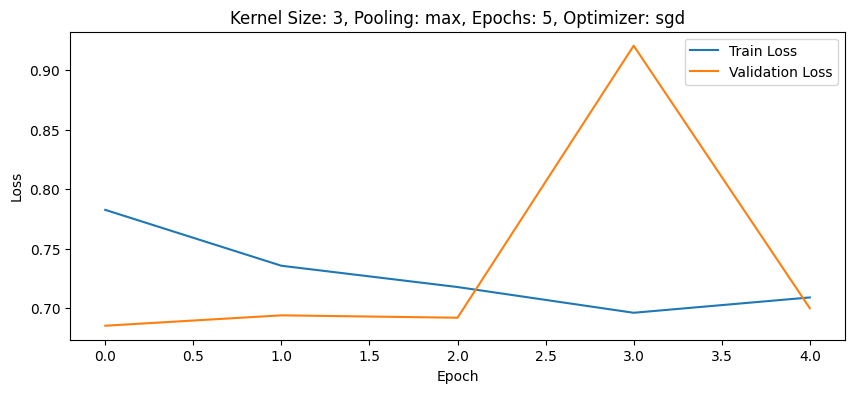

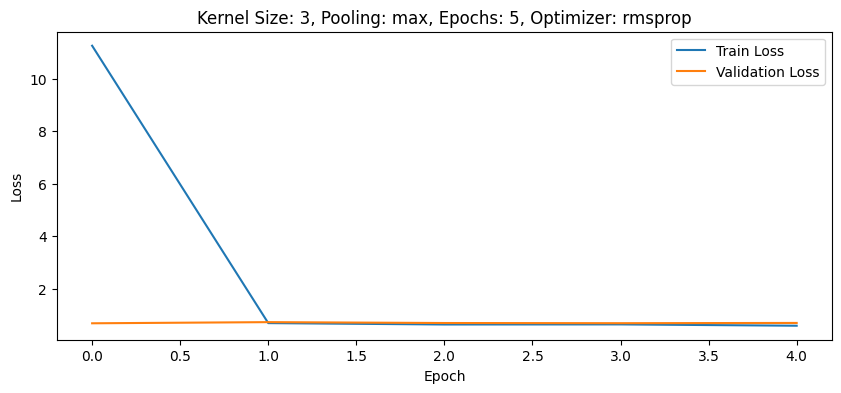

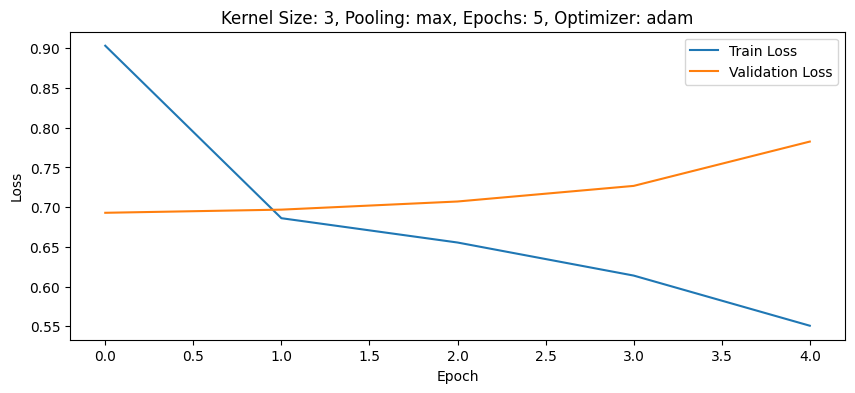

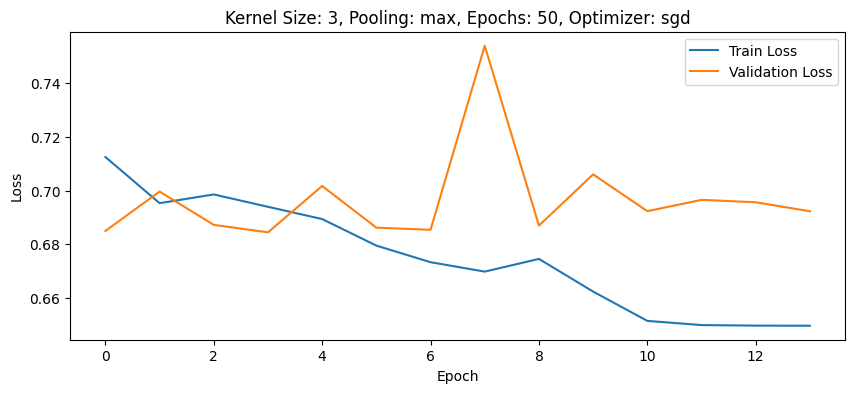

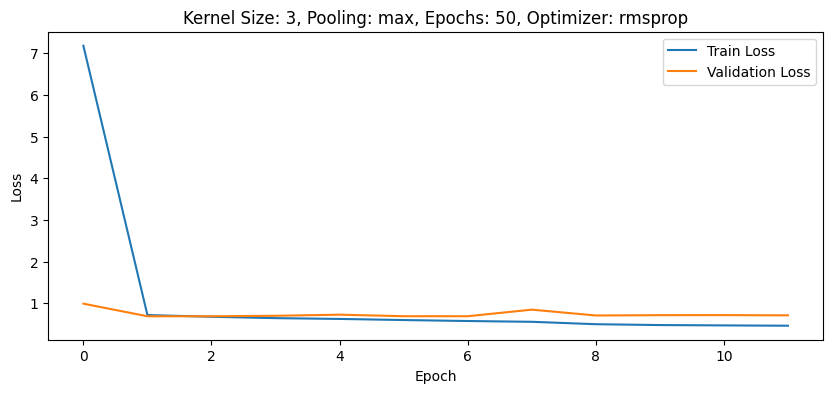

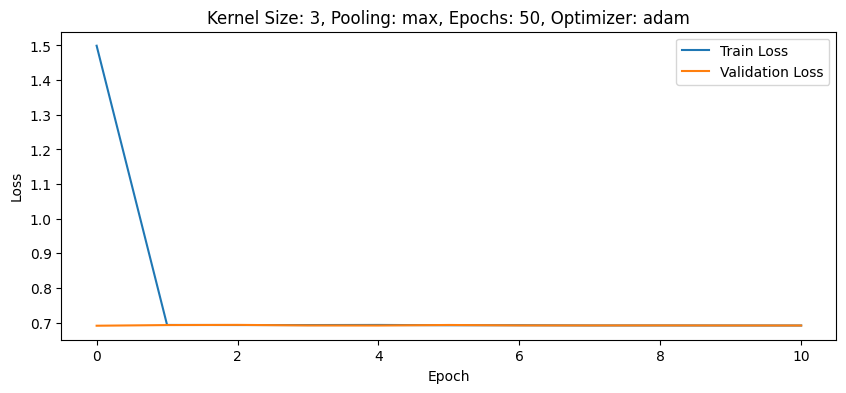

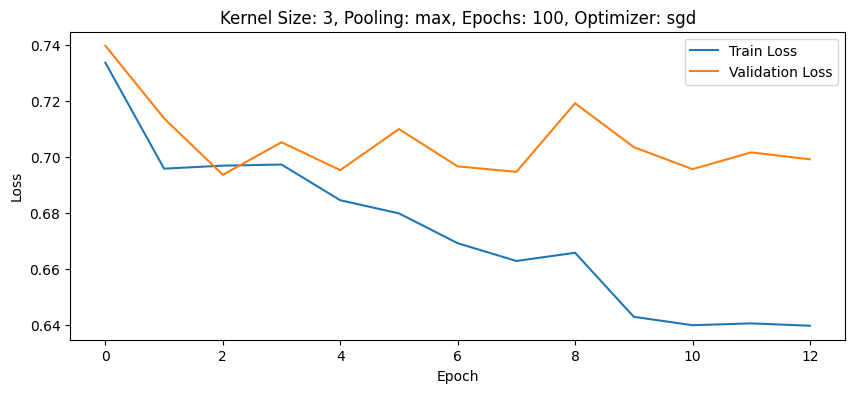

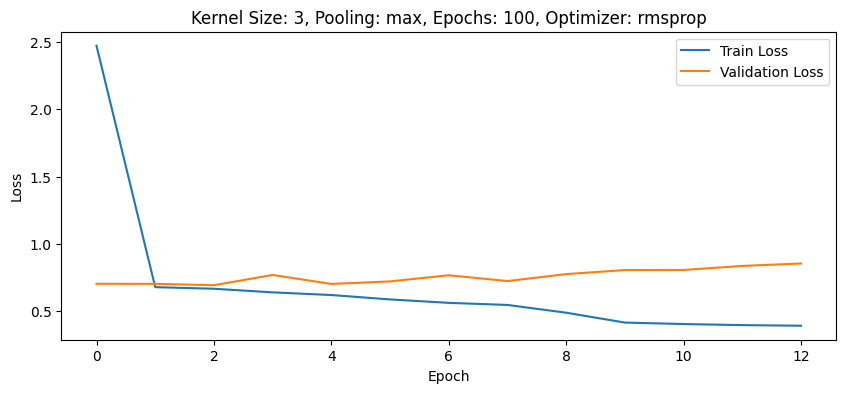

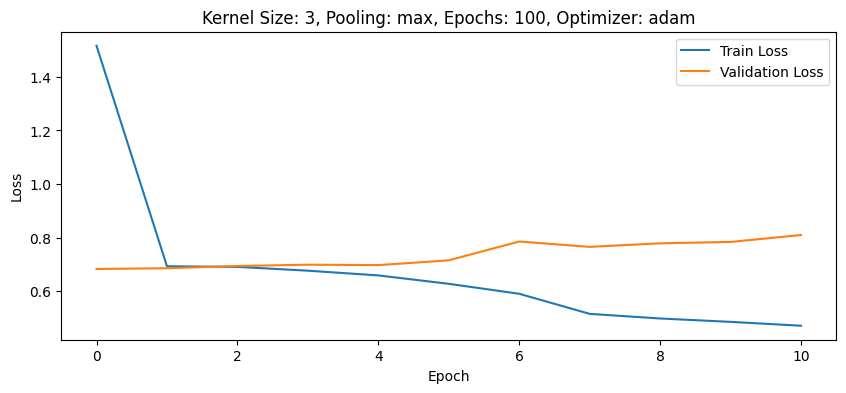

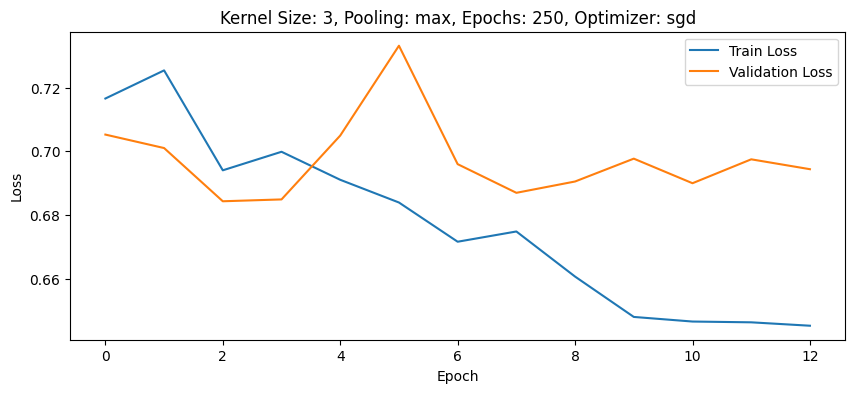

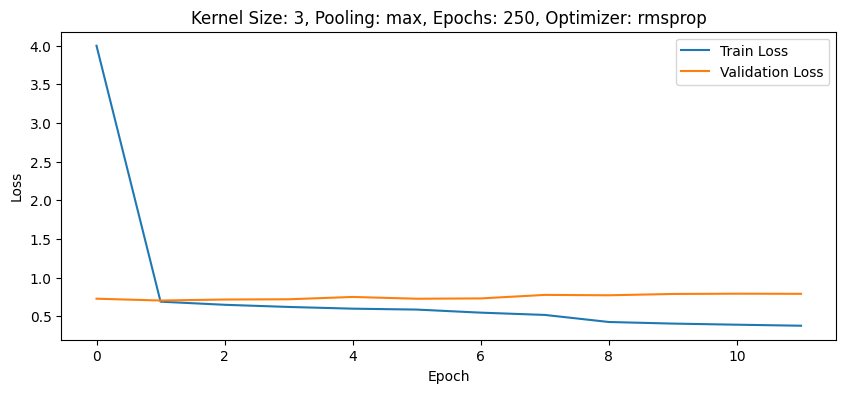

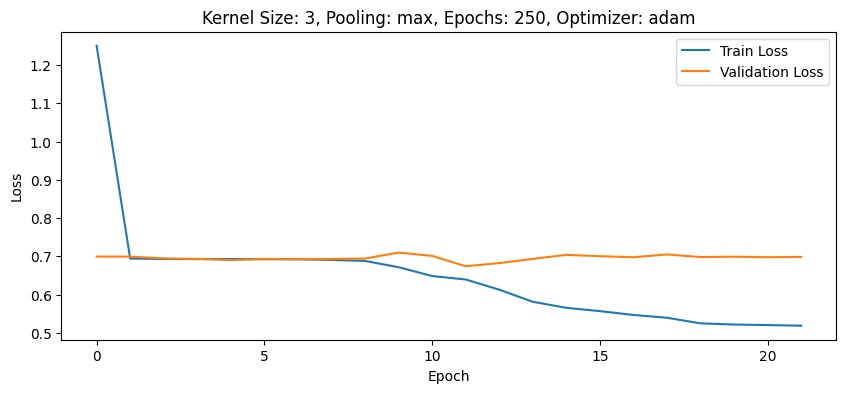

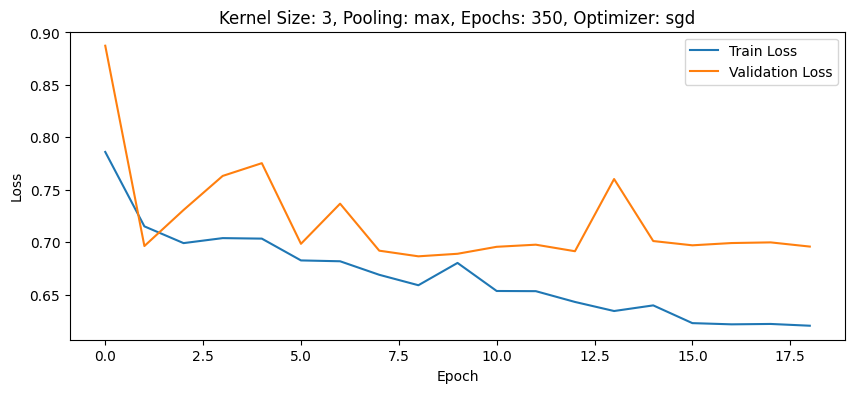

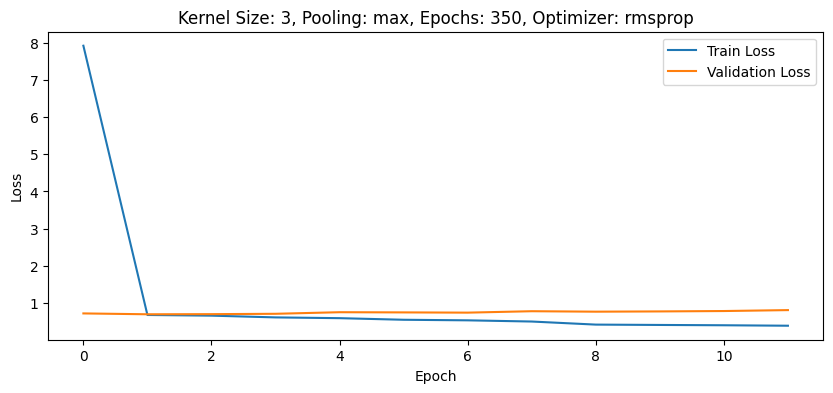

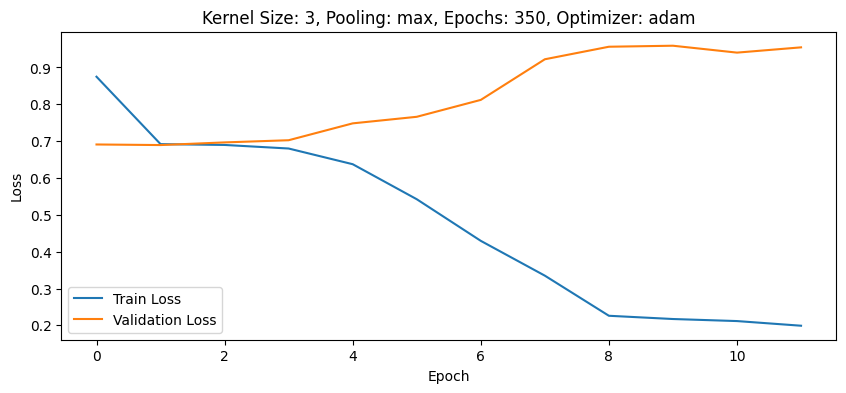

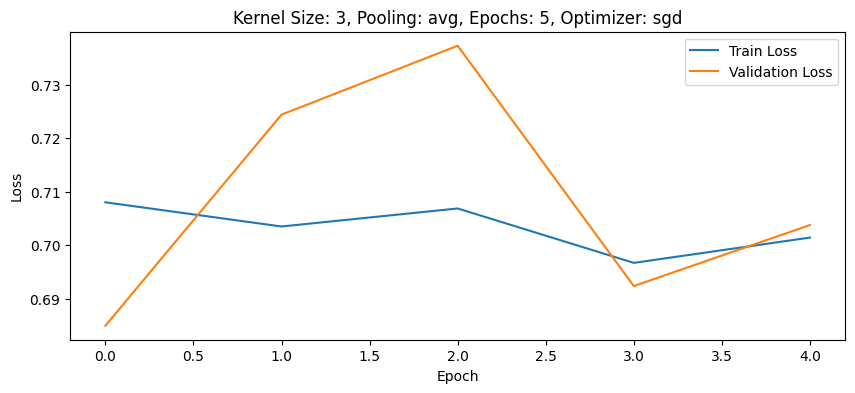

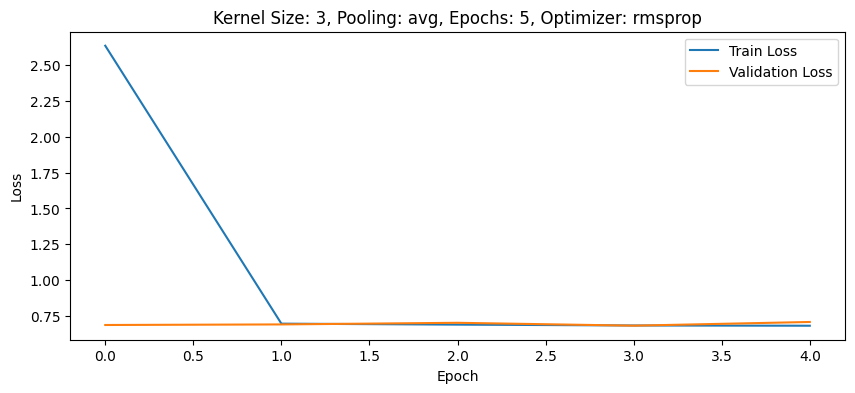

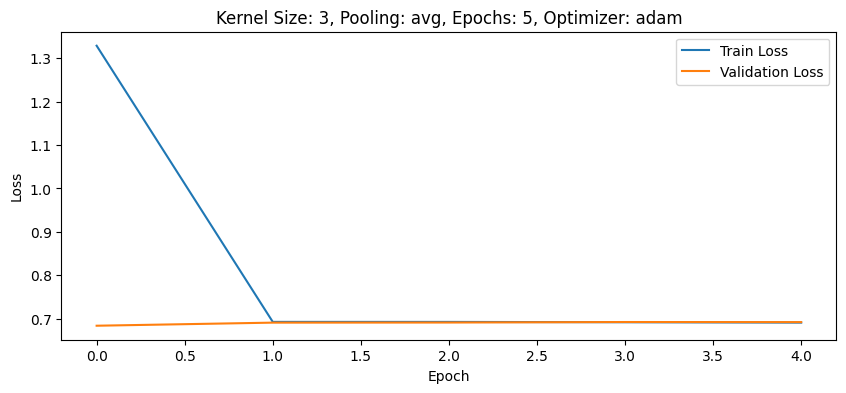

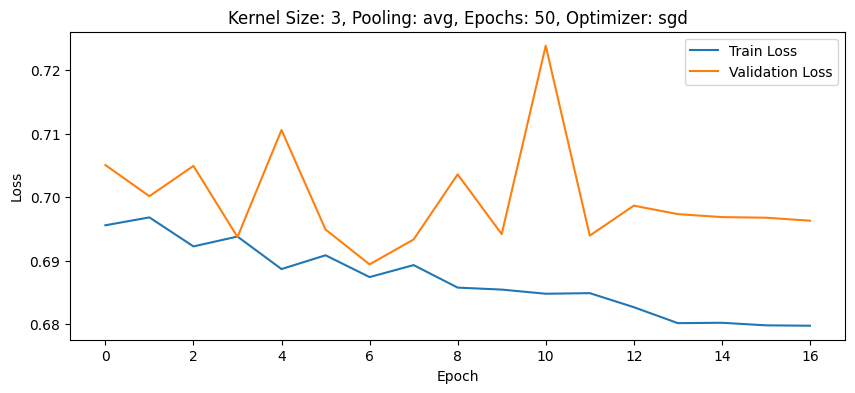

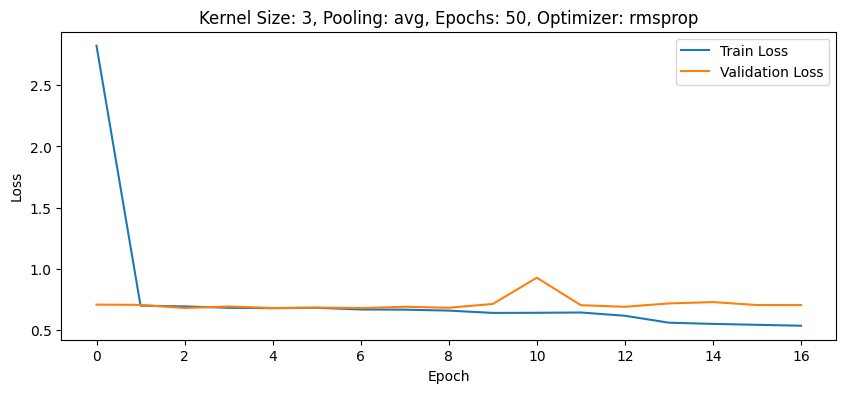

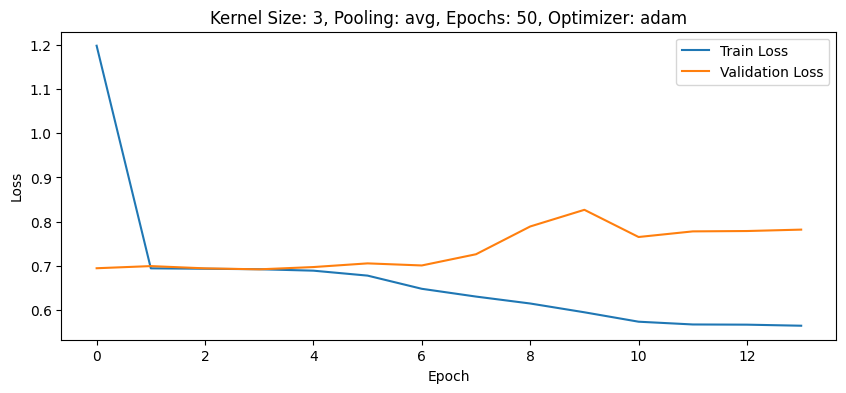

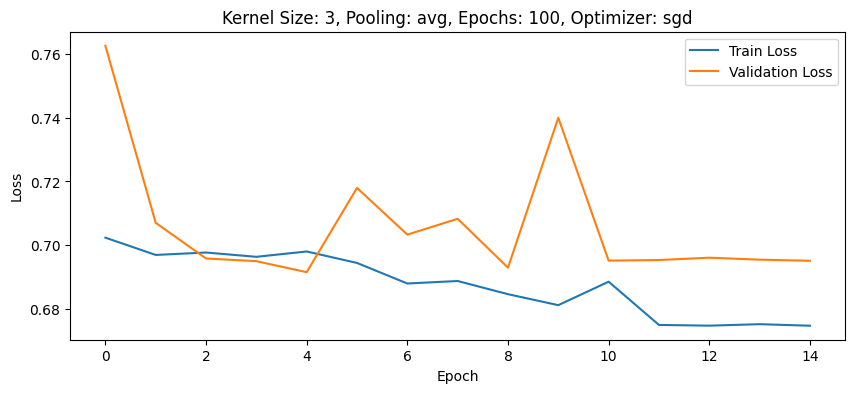

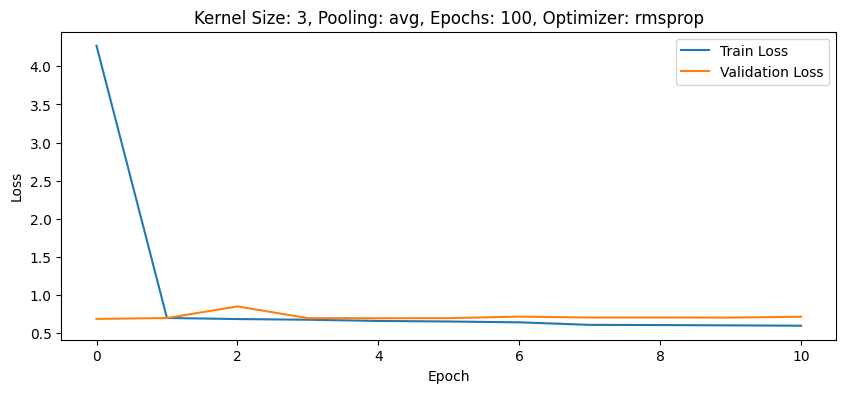

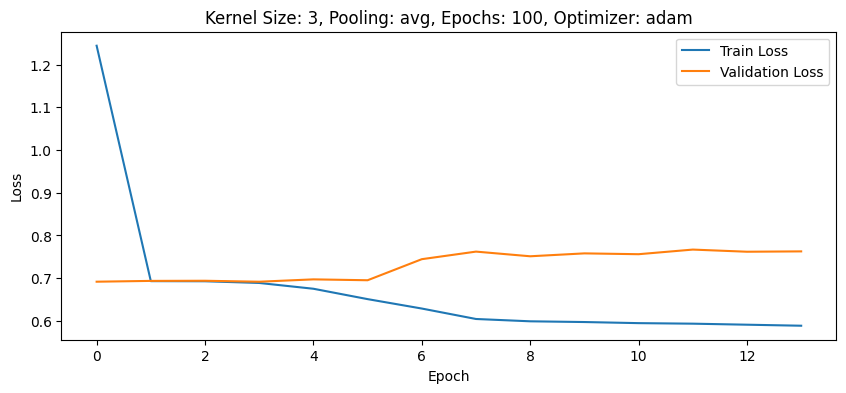

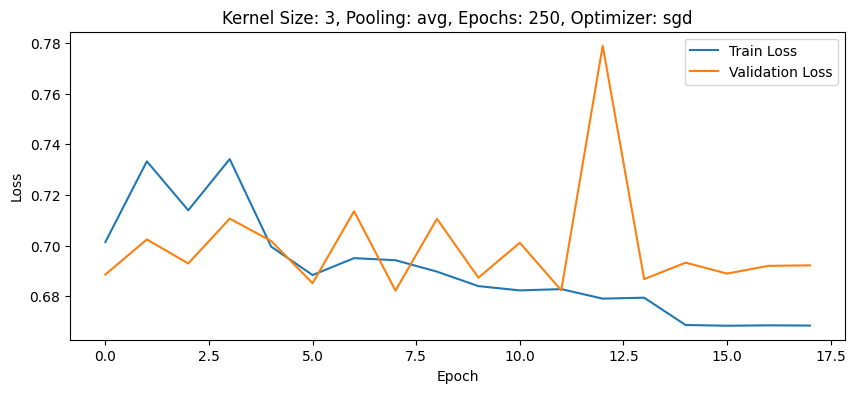

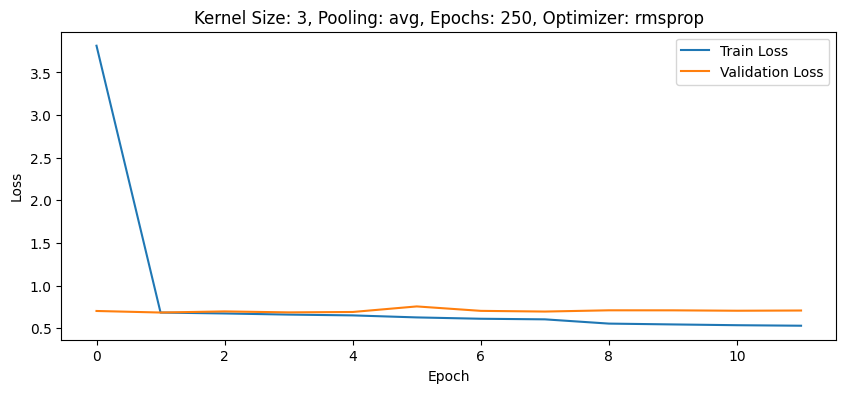

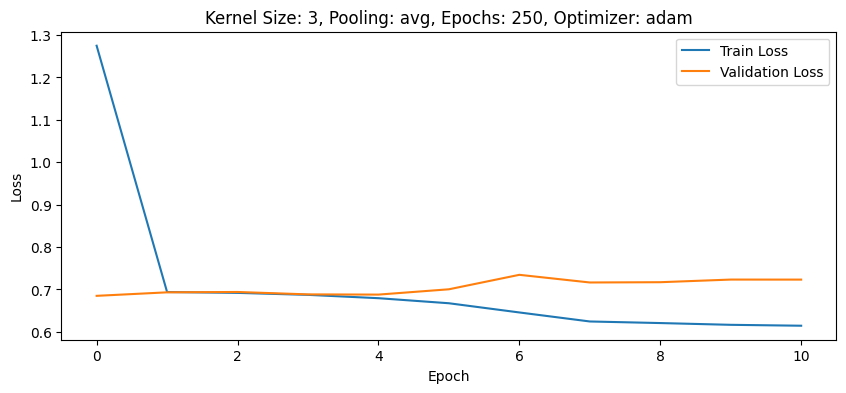

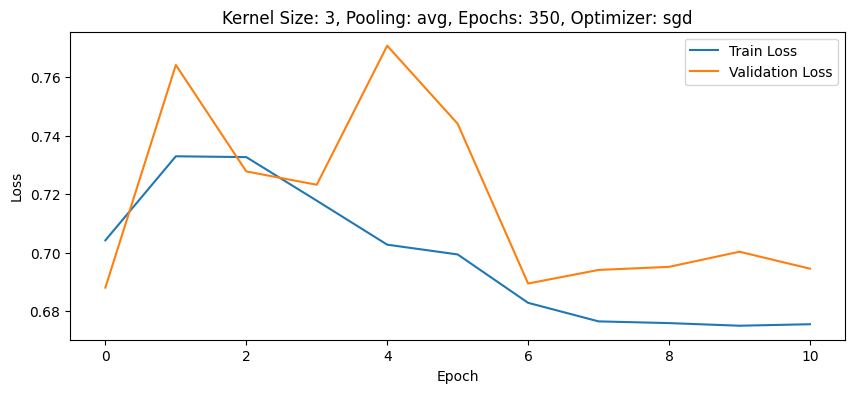

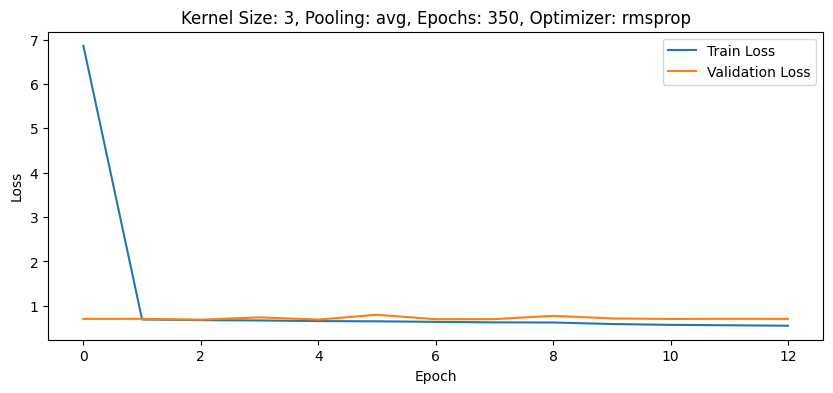

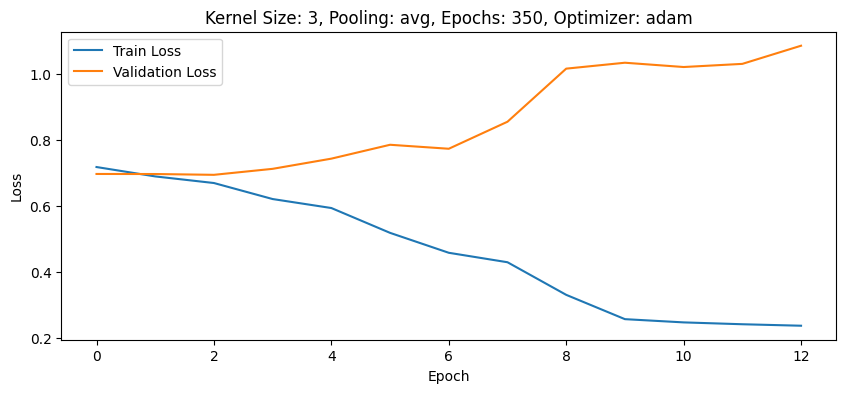

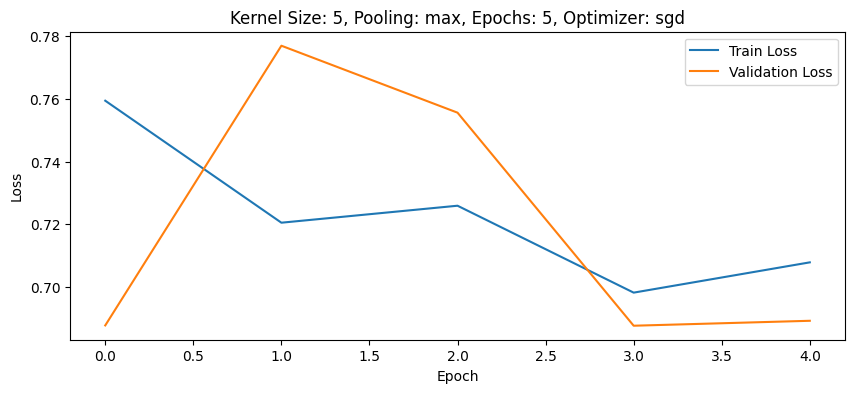

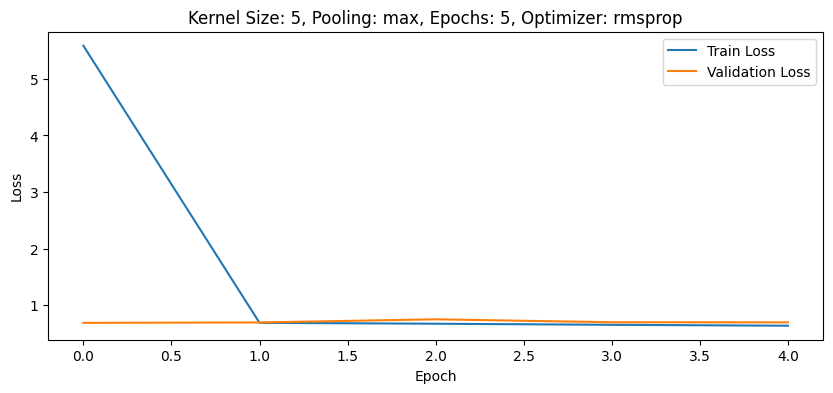

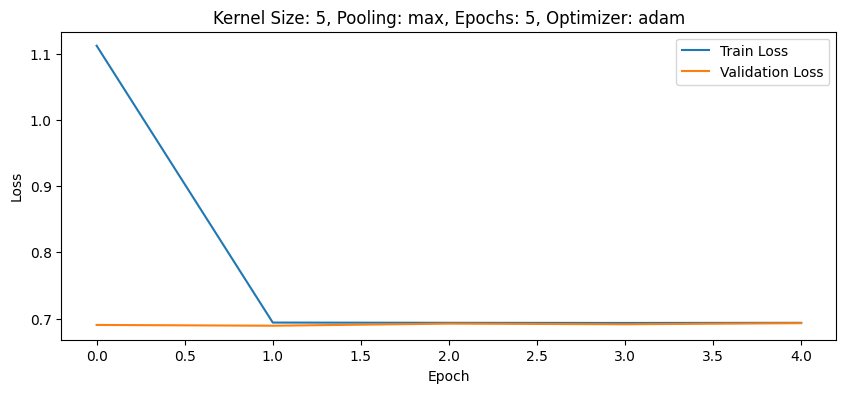

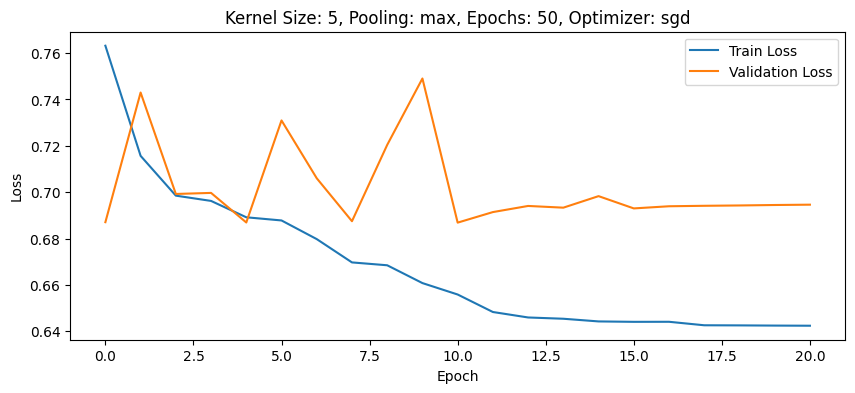

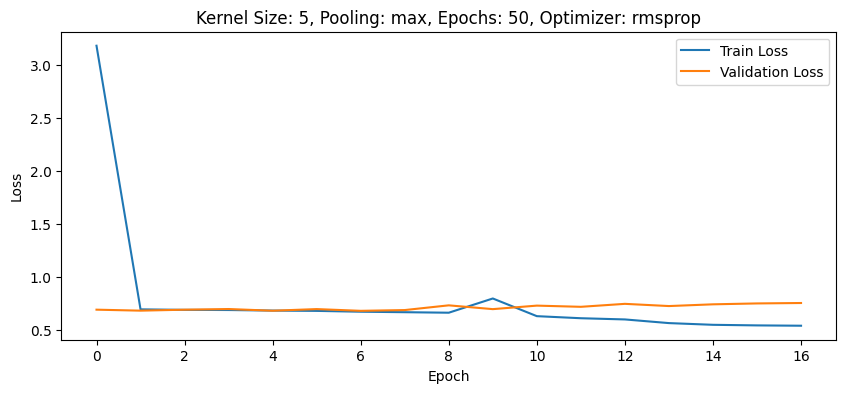

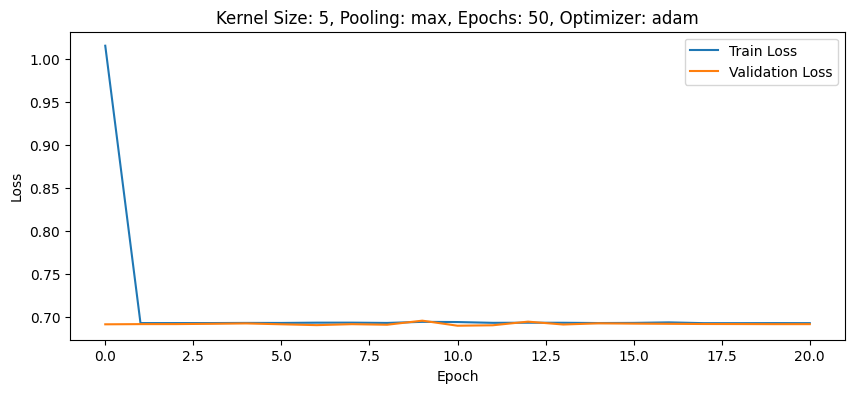

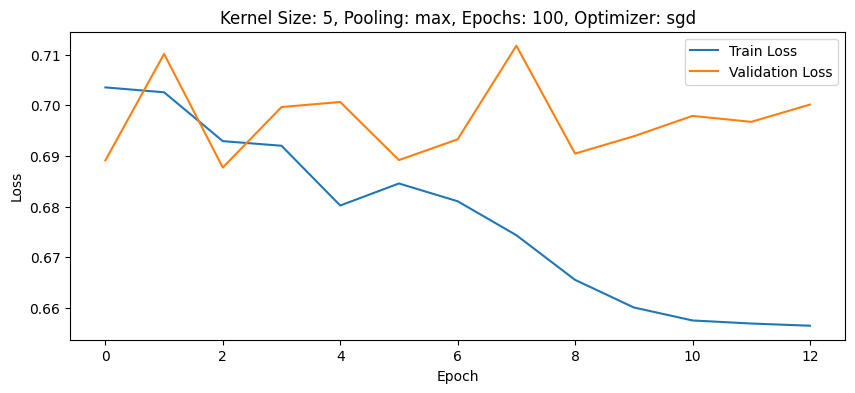

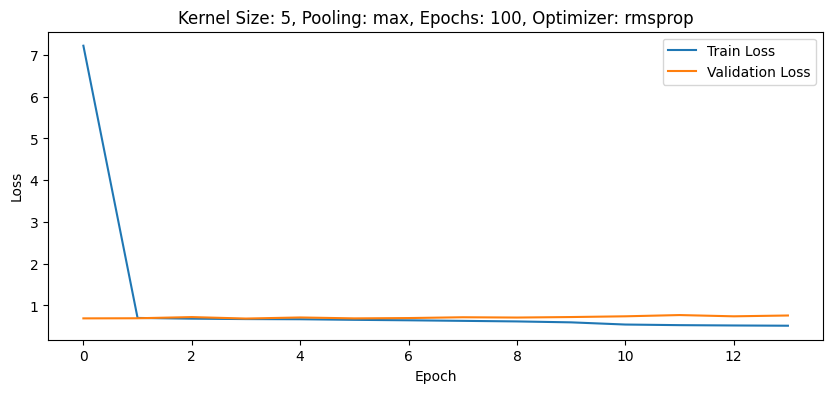

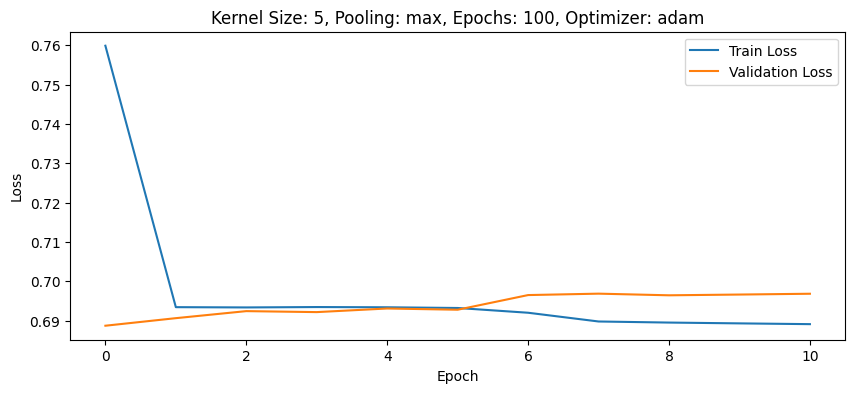

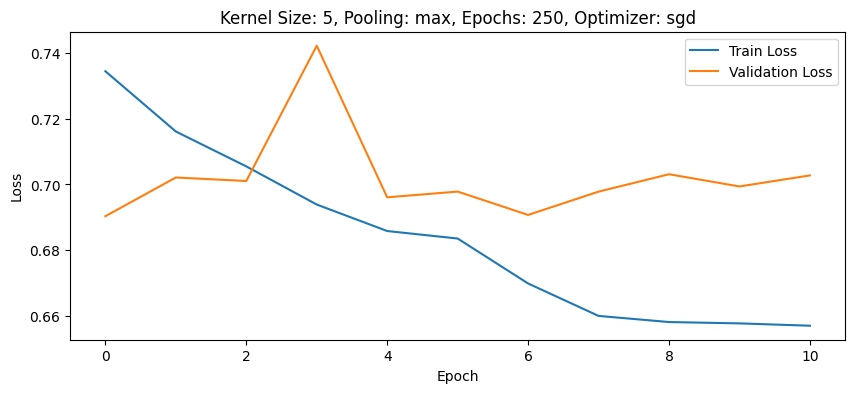

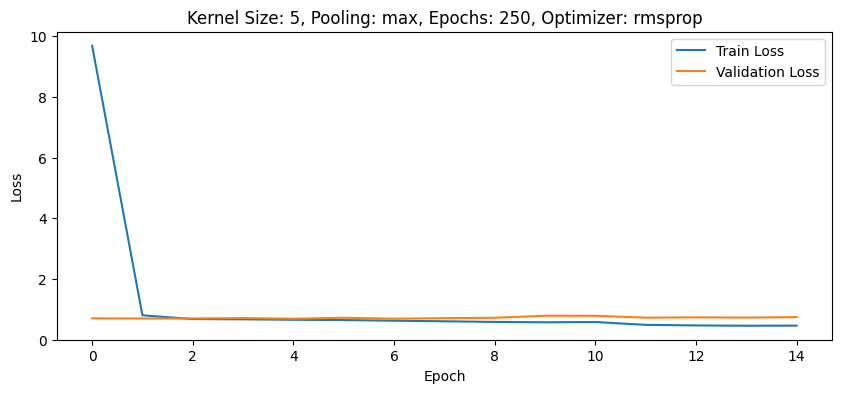

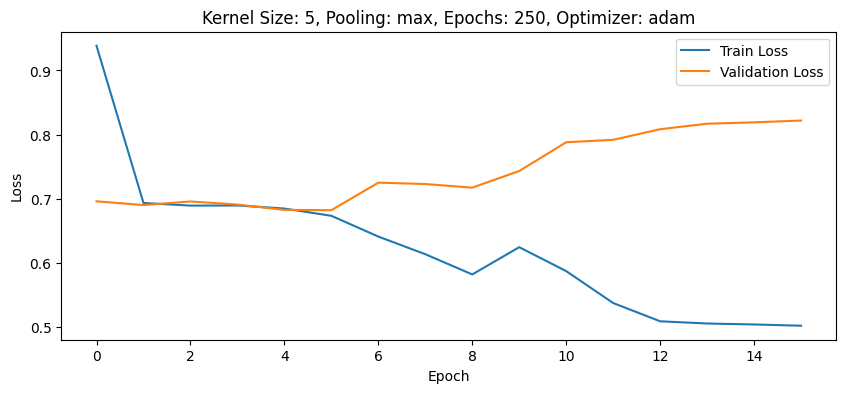

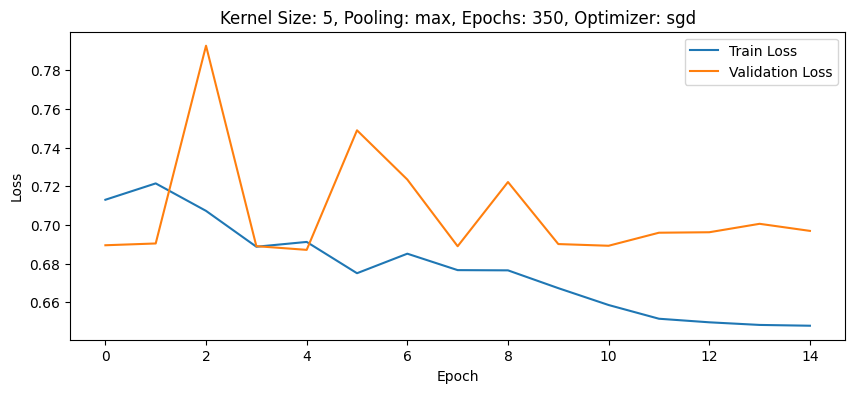

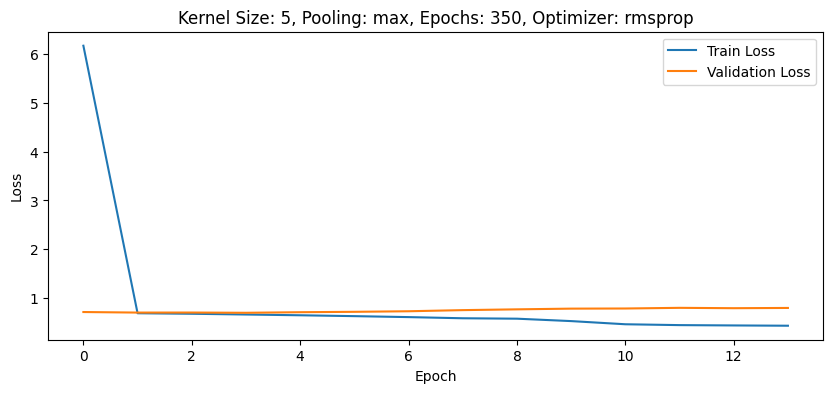

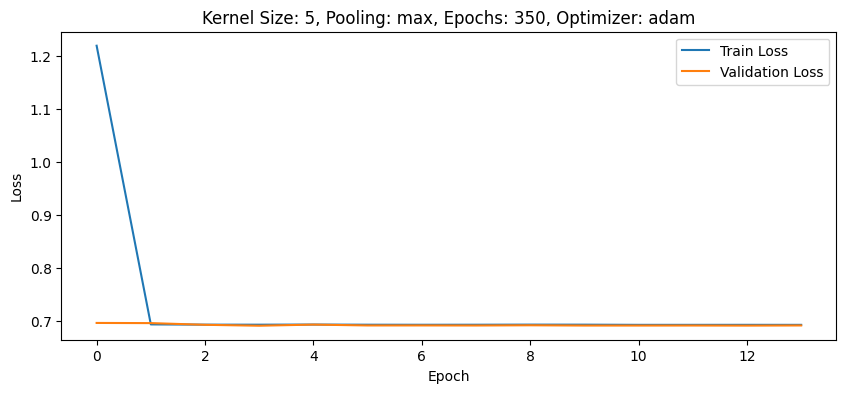

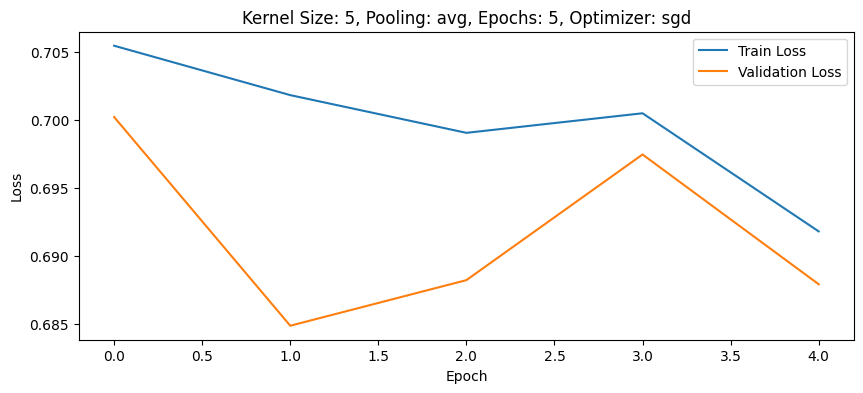

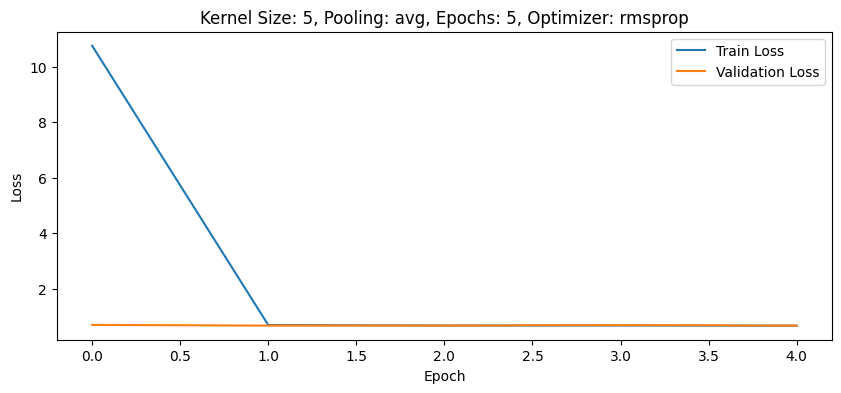

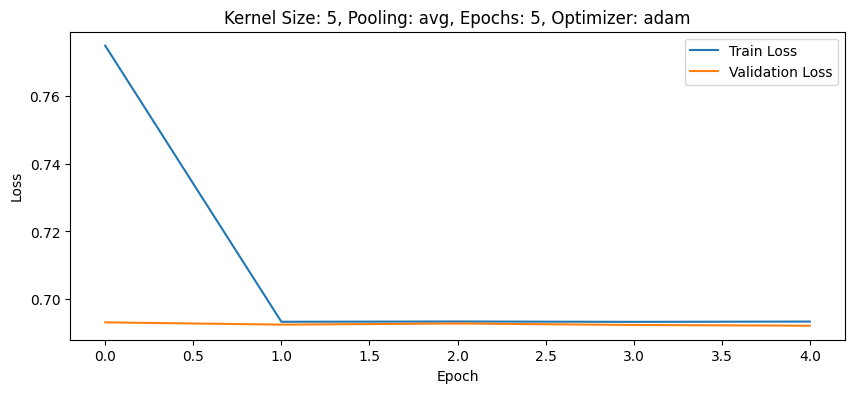

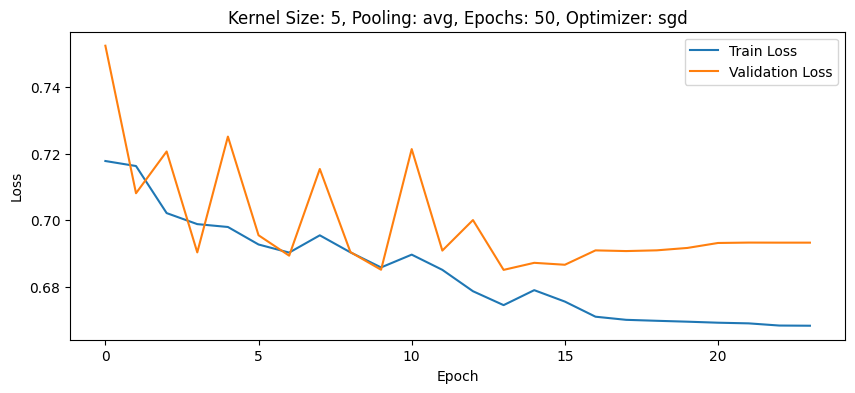

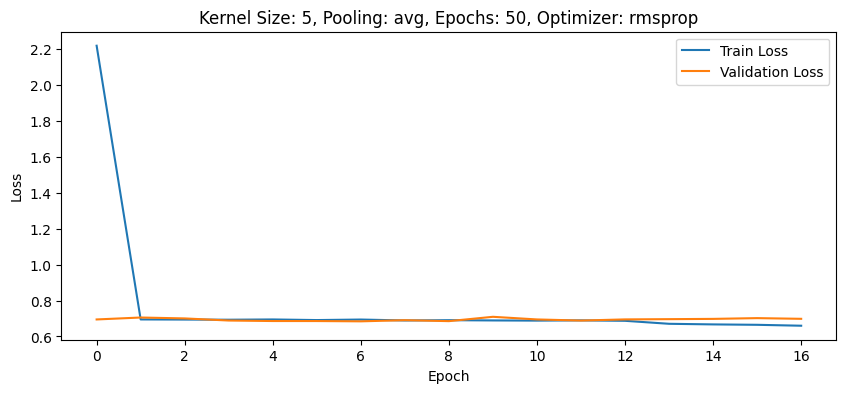

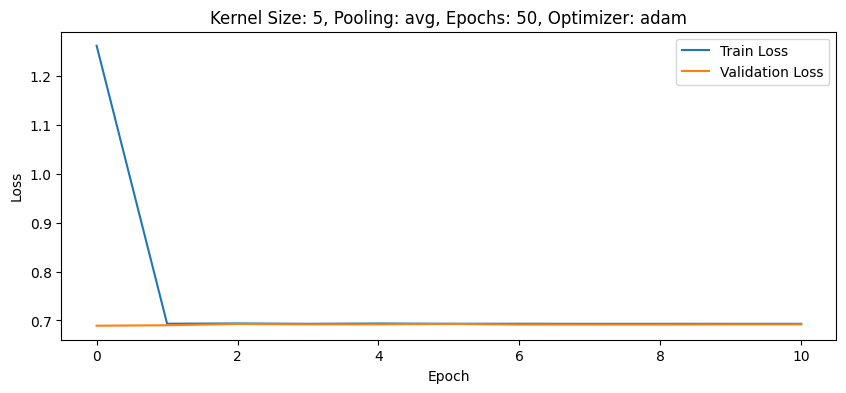

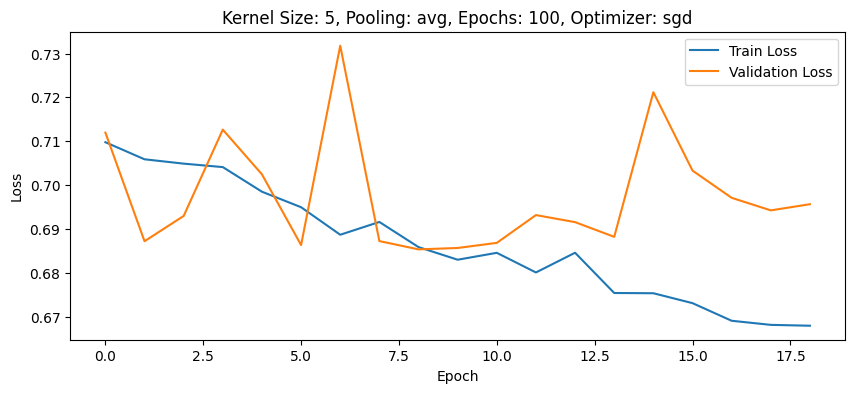

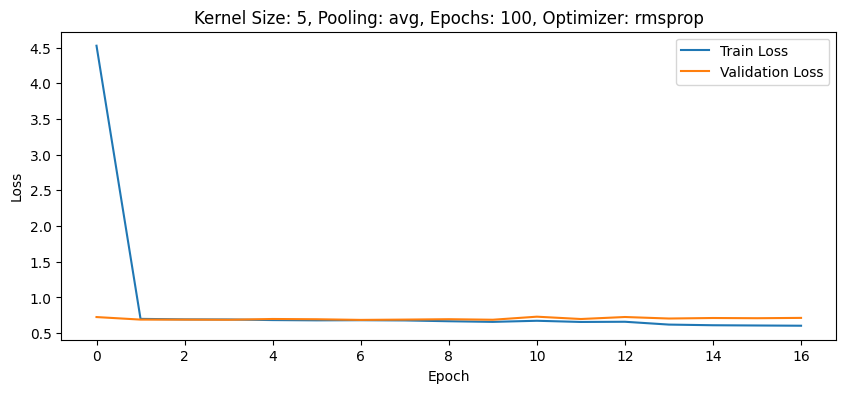

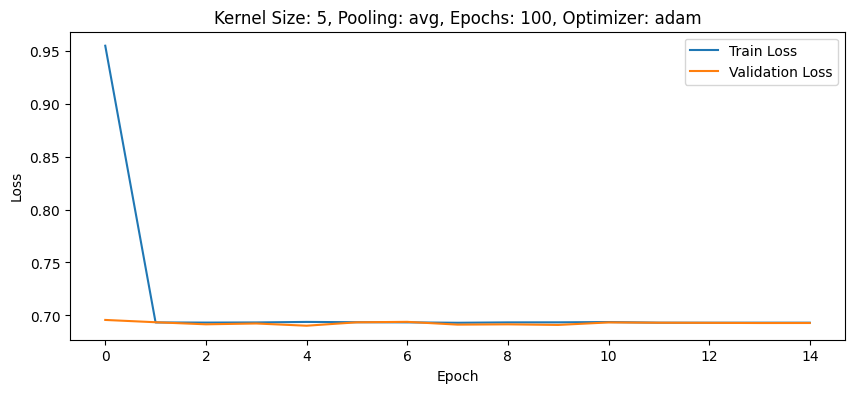

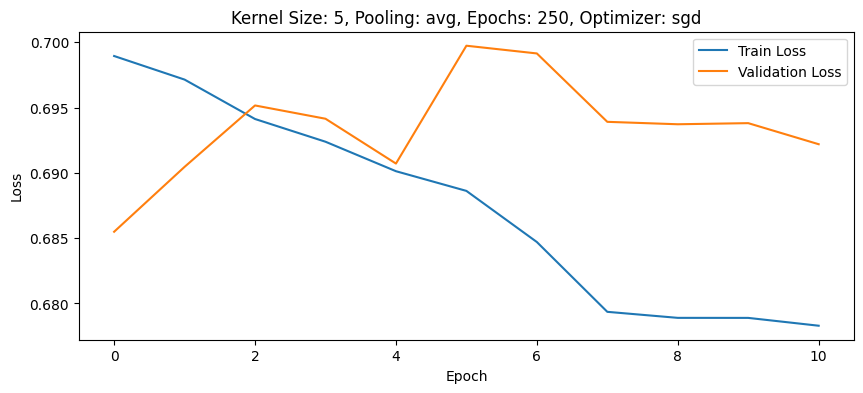

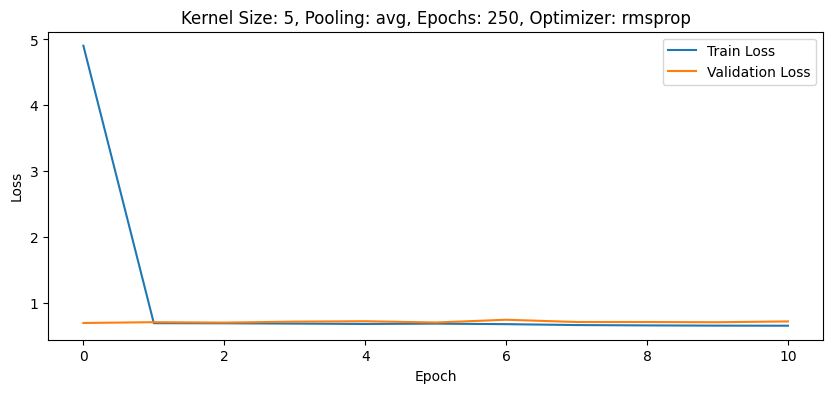

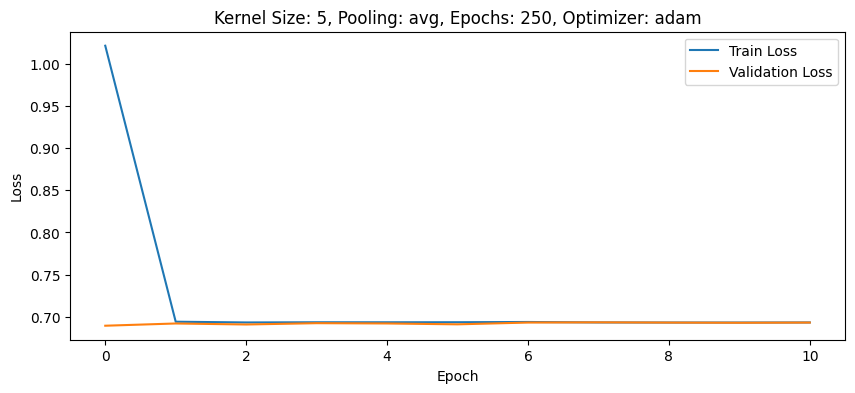

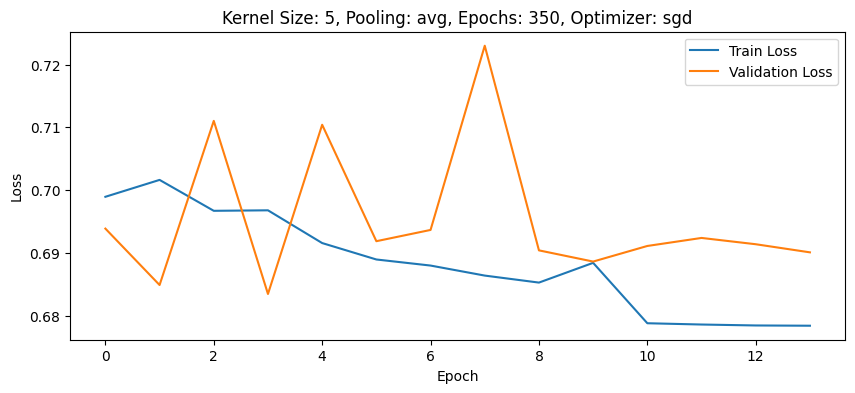

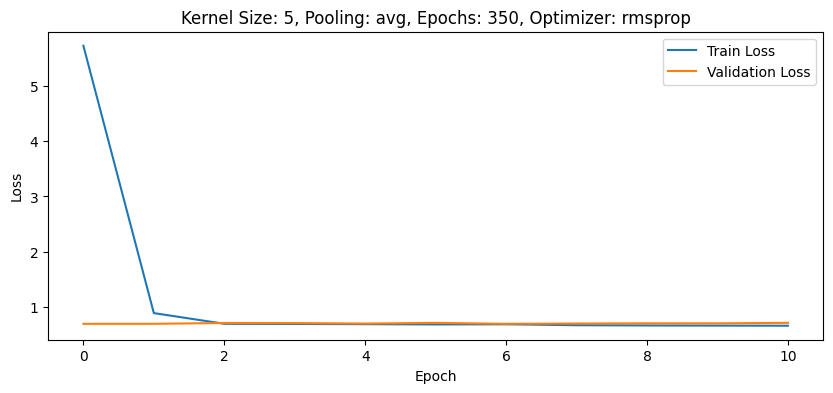

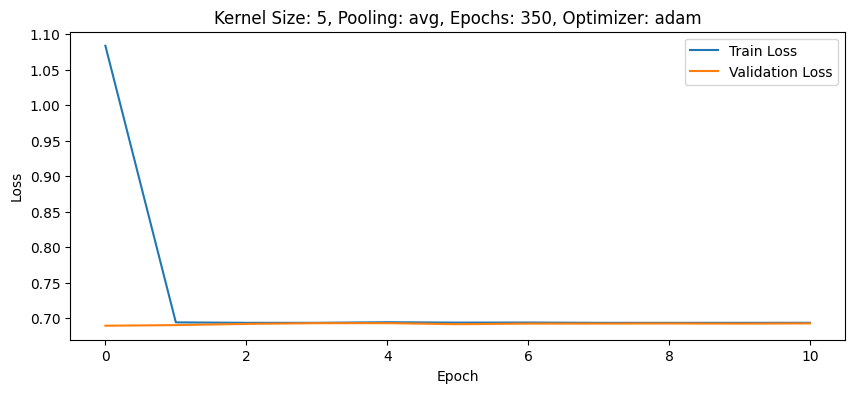

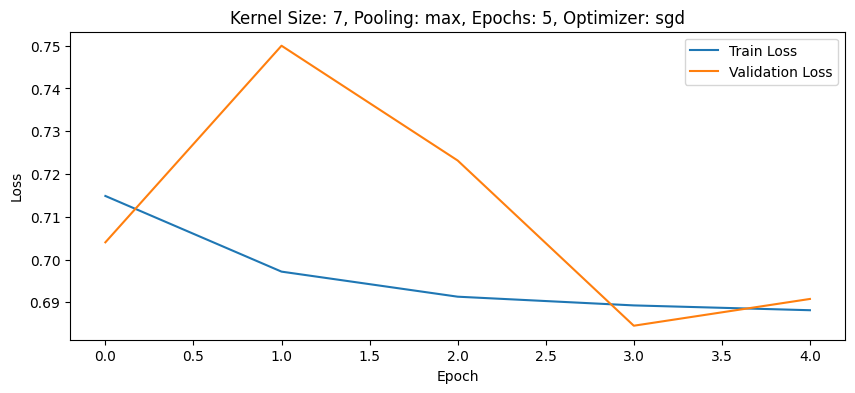

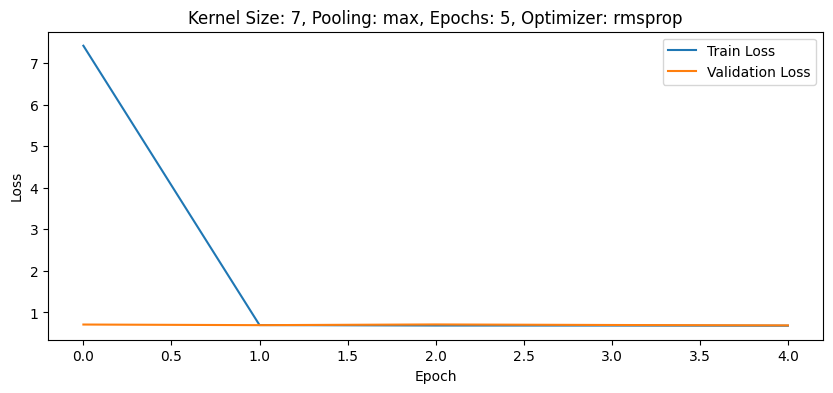

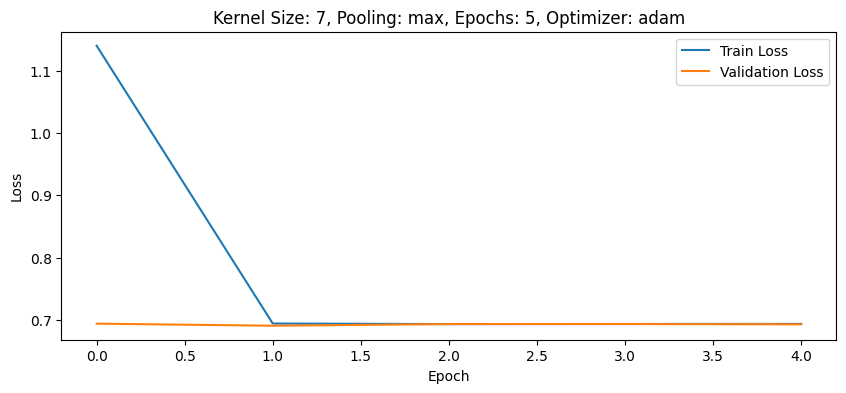

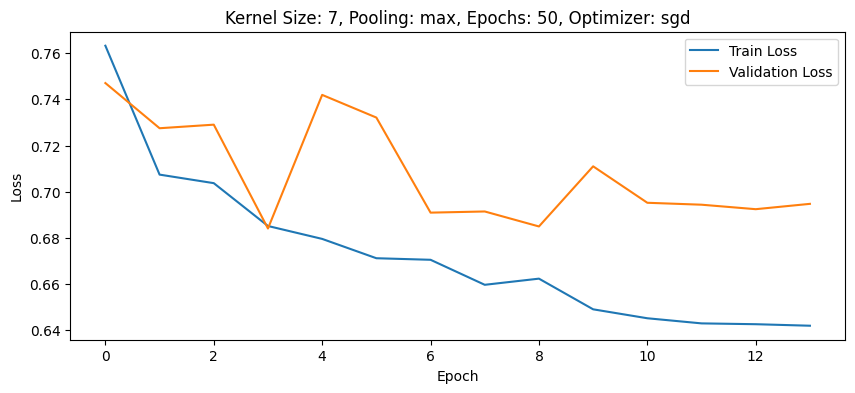

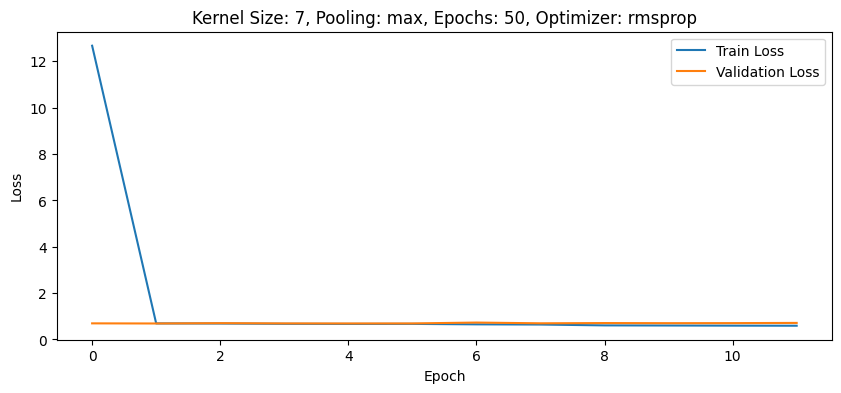

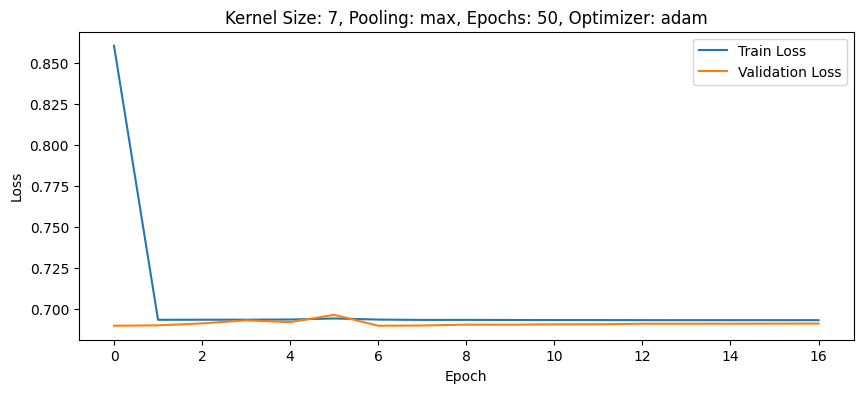

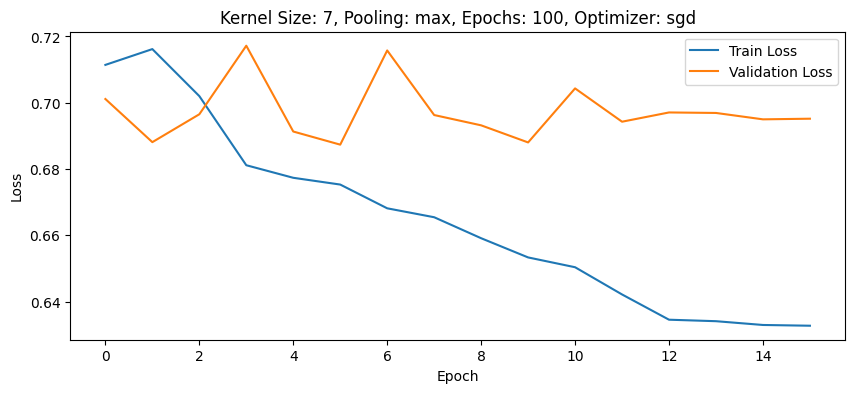

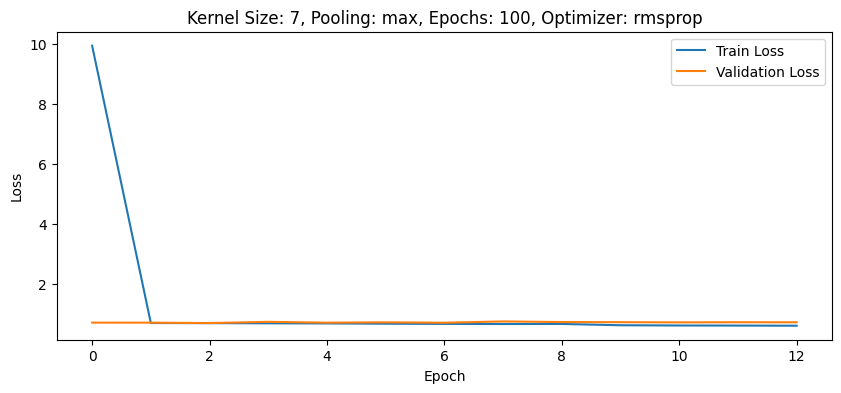

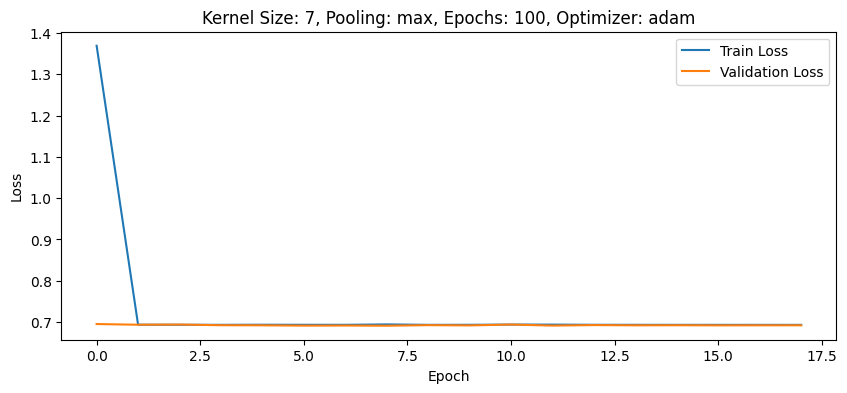

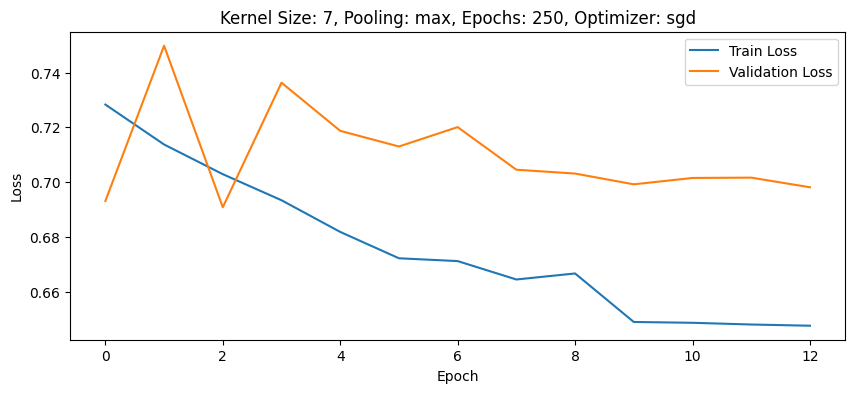

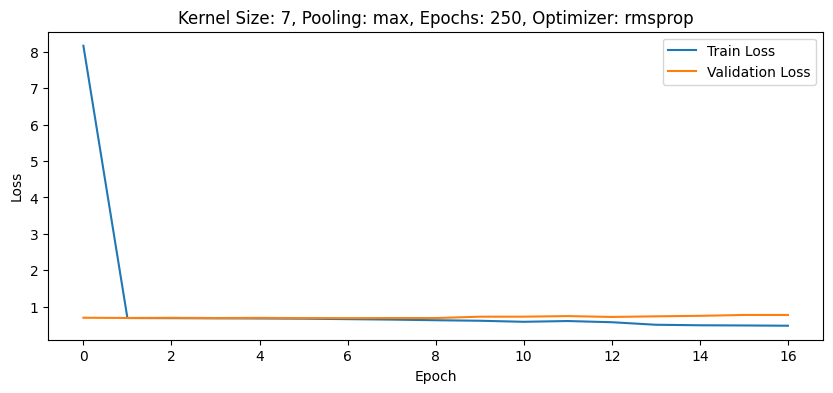

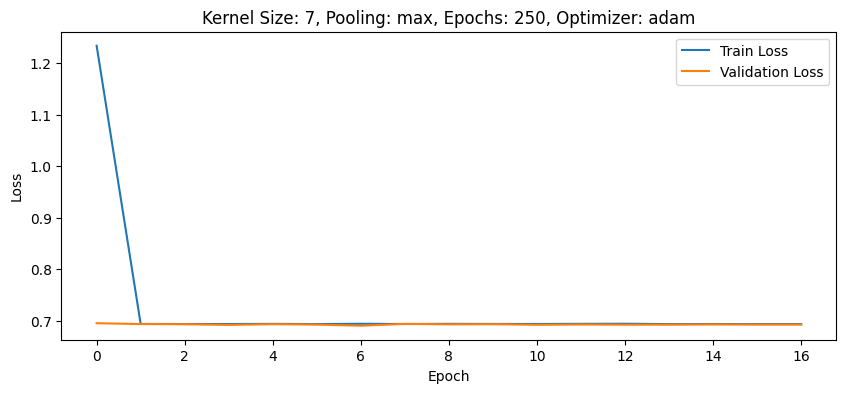

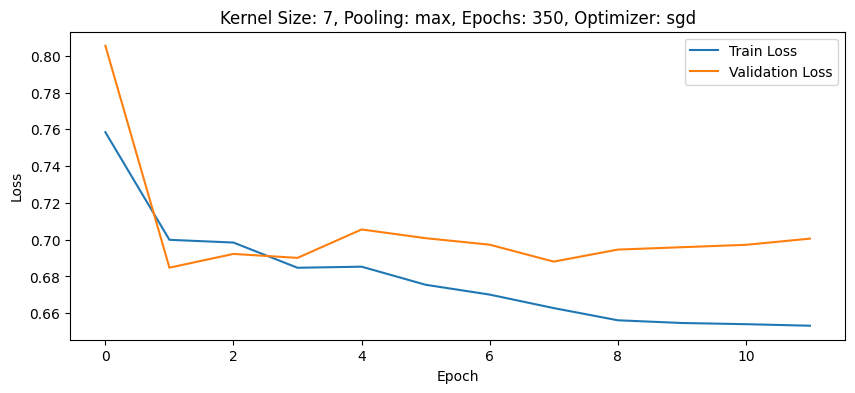

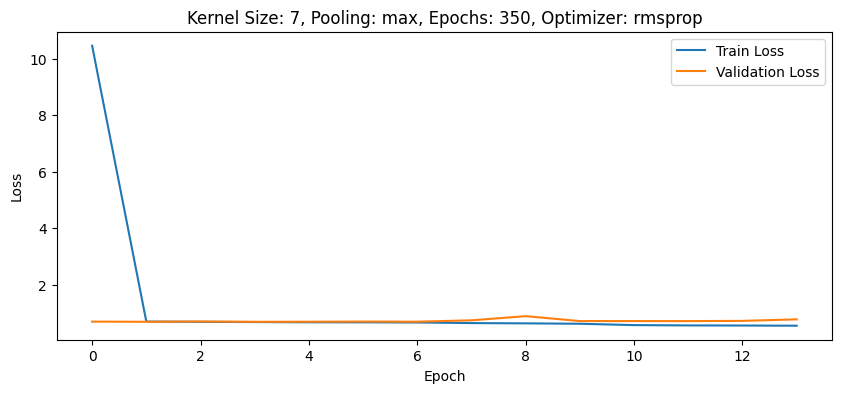

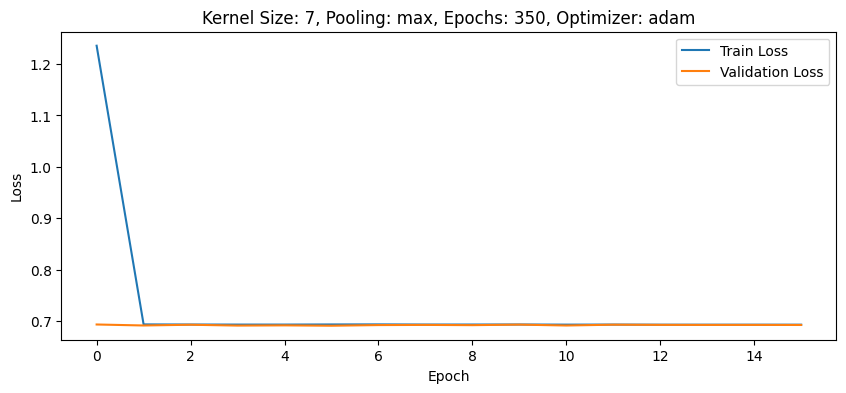

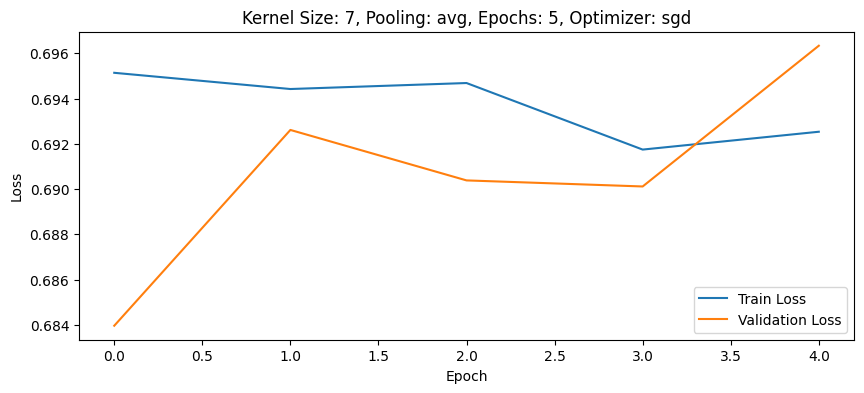

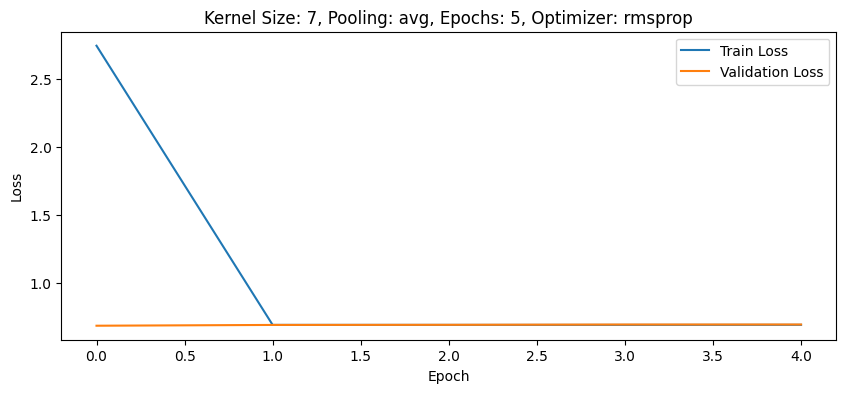

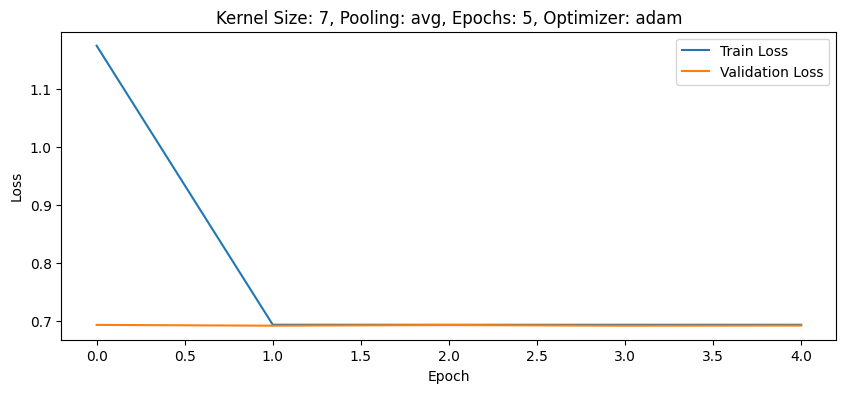

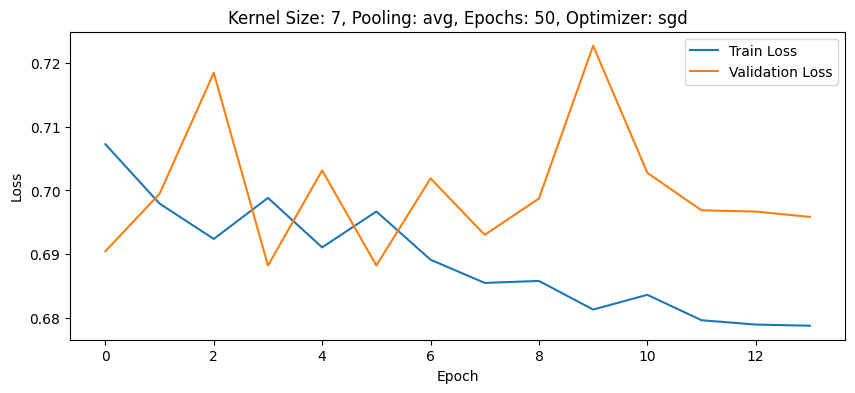

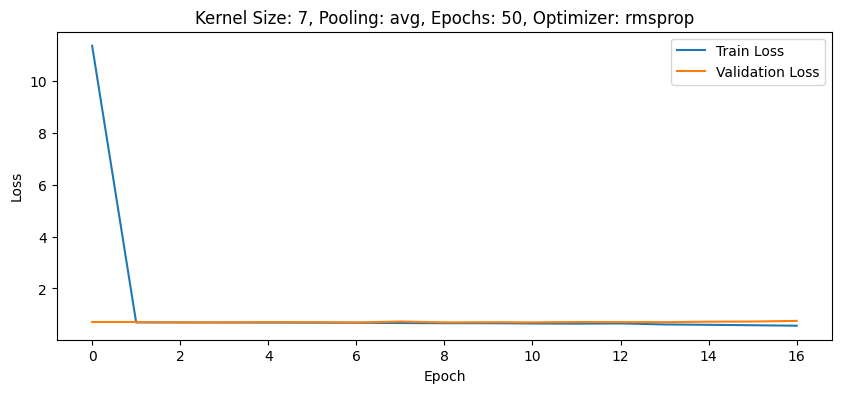

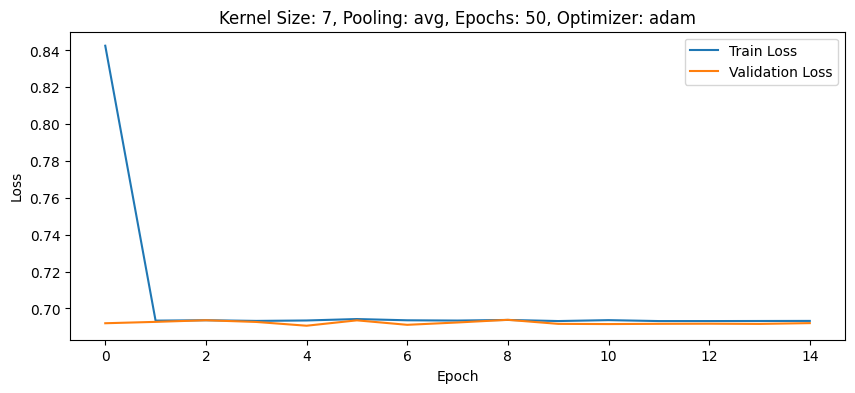

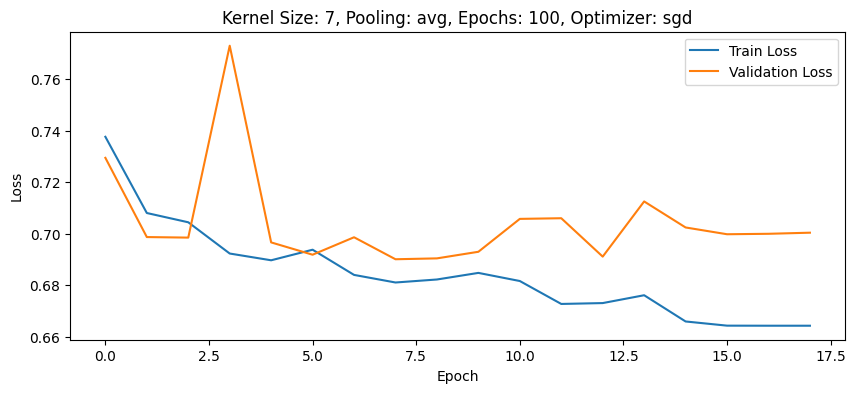

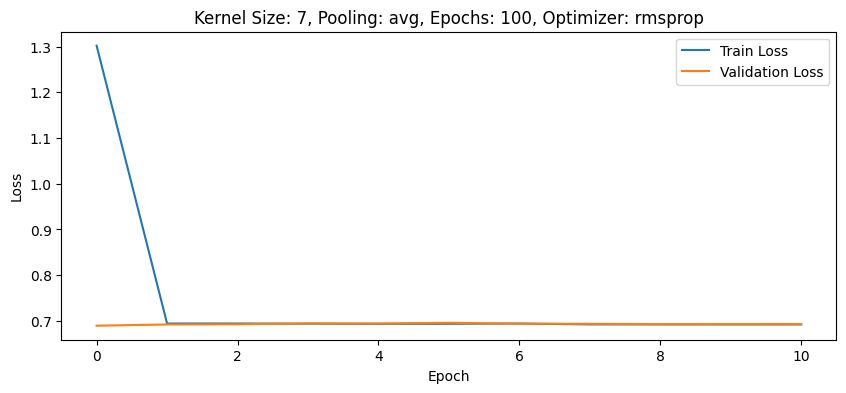

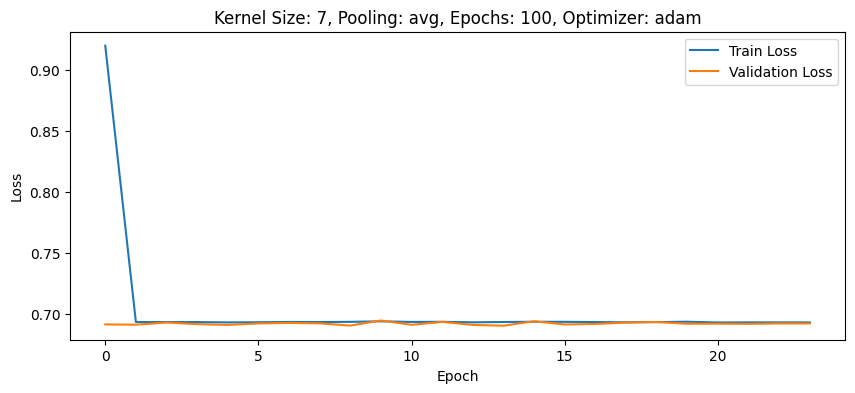

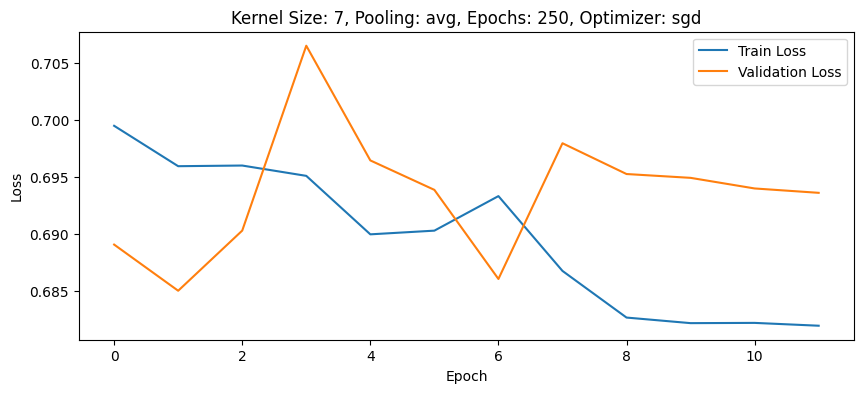

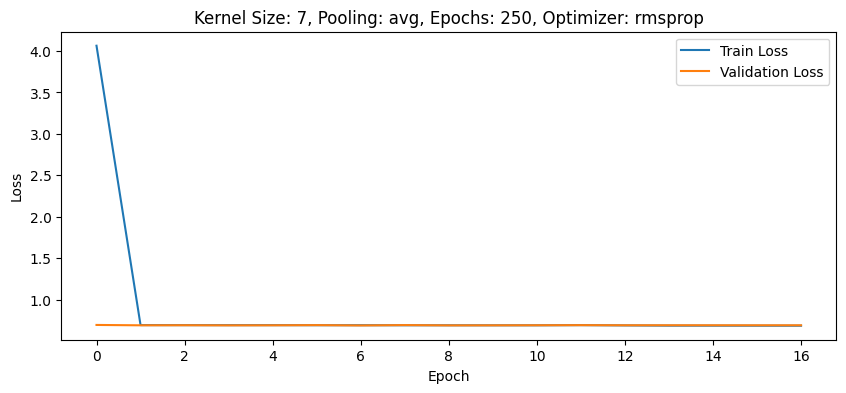

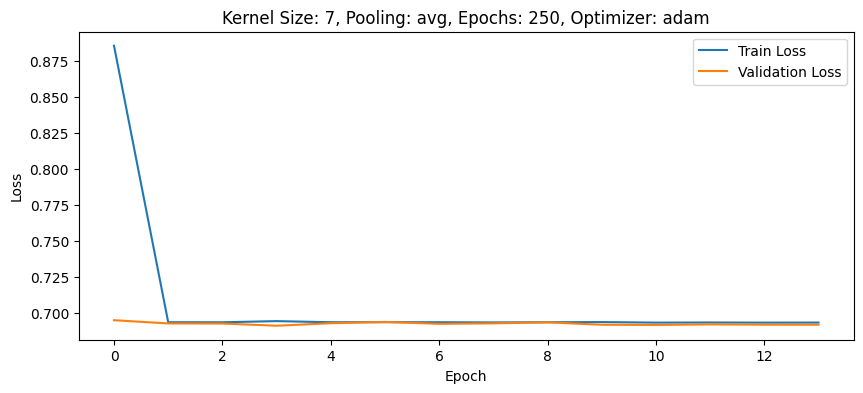

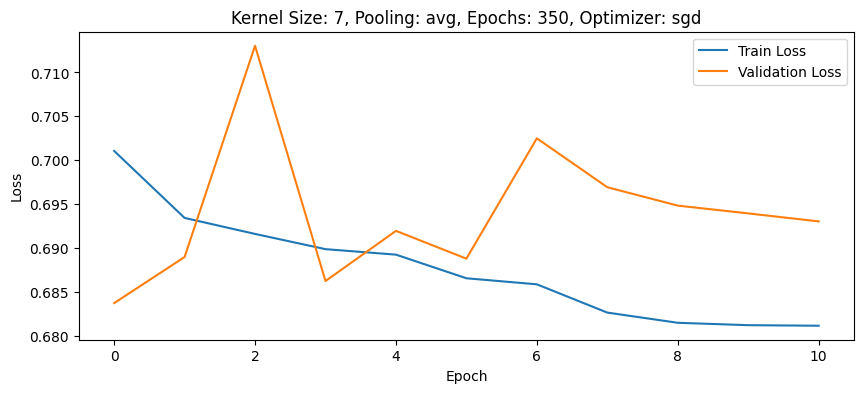

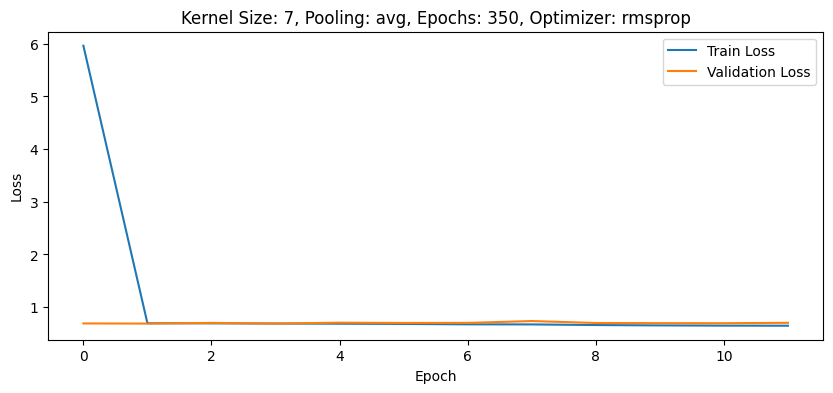

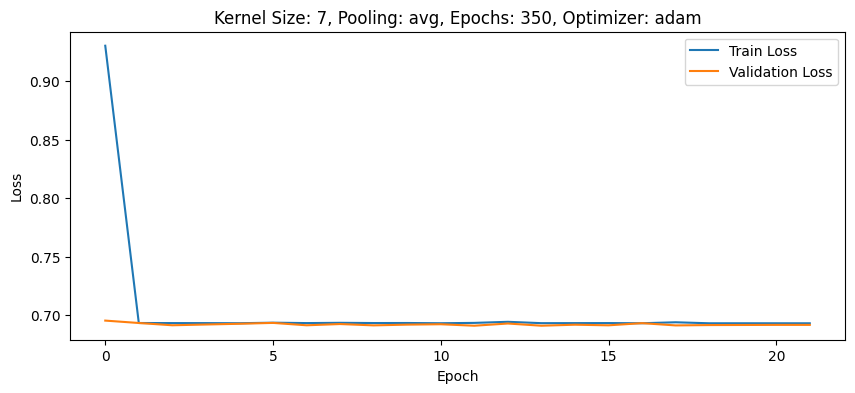

In [ ]:
# Visualisasikan hasil
for (ks,pool,ep,opt_name), losses in results.items():
  plt.figure(figsize=(10,4))
  plt.plot(losses['train_losses'], label = "Train Loss")
  plt.plot(losses['val_losses'], label = "Validation Loss")
  plt.title(f"Kernel Size: {ks}, Pooling: {pool}, Epochs: {ep}, Optimizer: {opt_name}")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()